## Work package 2.1 
### Delivering ...:
Methods (notebook) for compiling short-term time-series  (e.g., monthly)  of EO data for WQ monitoring: 
Filtering of outliers and inferior data (insufficient radiation, glint, shadowing, bottom-reflectance) 
Apply corrections (dark-pixel subtraction)
Define areas of water (at time of observation)
Compilation to bi-monthly and monthly values

Time-series will need to cover: 
Baseline period
Monitoring period
Time of observation (i.e., recent)


### Dependencies etc.

In [1]:
# --- --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
from scipy import stats
import pandas as pd     #for dates
from odc.ui import image_aspect

dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [18]:
# --- run code for functions that are called
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown

In [3]:
from deafrica_tools.plotting import rgb

In [4]:
# --- controlling parameters and settings
verbose = True
test    = False
max_cells = 100000   #use this to test memory limits. Memory saving steps are going to be needed...

#### Set the place and time interval

In [23]:
# --- get the dictionary of all possible places for analysis ---
places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
year1, year2 = None, None
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename = 'SA_smalldam'   
placename,year1,year2 = 'Lake Chamo','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Ziway','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Awassa','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake_Manyara','2015-12-01','2016-03-31'   
placename,year1,year2 = 'Lake_vic_turbid','2018-1-01','2018-07-10'


# a good example for monitoring - (35.7236, 35.9286) (-3.8135, -3.4085), late 2015, to 2016-02-16   
# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(
                               placename,
                               #'2015-12-01','2016-03-31',
                               #'2018-1-01','2018-07-10',
                               year1 = year1, year2 = year2,
                               max_cells = max_cells,
                               verbose=verbose,test=False)


Lake_vic_turbid AOI:  {'x': (34.6, 34.7), 'y': (-0.25, -0.2), 'time': ('2018-1-01', '2018-07-10')} Lake Victoria turbid area in NE
Grid resolution will be: (20, 20)
Rough dimensions (x,y):  9  by  4 kilometres
Total cells is roughly:  124998
Cell area is:  0.0004  km2
Resampling : bilinear
Site name:  Lake Victoria turbid area in NE
Years: 2018-1-01 2018-07-10


### Extract a multi-sensor dataset 
- keeping all data in a single dataset
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- instrument names are used rather than satellite names, to avoid confusion. For these purposes, wofs is also an instrument name
- re-using functions developed for the annual time-series where possible


In [24]:
# --- set which instruments to use (this is checked later against the date range for each place)
# --- The geomedians are retained as a reference for filtering of outliers.
# --- The returned dataset should have everything in one ..
# --- switch off the non-annual datasets to allow the annual build function to be used separately 

_instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': False},  # wofs_all will be removed as it is better to derive from wofs_ann
    }

instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

# --- for a couple of purposes extract the year from the start and end times ..
y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]
 
# --- don't try to use instruments for which there are no data#

check_instrument_dates(instruments_to_use,y1,y2,False)

# --- build the multivariate/multi-sensor dataset. 
#     Datacube calls are made to extract the primary data. 
#     Variables are-re-named and merged to a single dataset ---

#build the annual dataset first:
spacetime_domain_ann = spacetime_domain.copy()
if y1 == y2: y1 = y2 - 1
spacetime_domain_ann['time'] = (str(y1),str(y2))

ds_annual =  build_wq_agm_dataset(spacetime_domain_ann,instruments_to_use,verbose)
print("\n Annual datasets loaded")


Building the dataset:
loading data for  oli_agm ...
loading data for  msi_agm ...
loading data for  wofs_ann ...

 Annual datasets loaded


In [25]:
# --- now build the other datasets ---

_instruments_to_use = {
    'oli_agm'  : {'use': False },
    'oli'      : {'use': True},
    'msi_agm'  : {'use': False },
    'msi'      : {'use': True},
    'tm_agm'   : {'use': False },
    'tm'       : {'use': True},
    'tirs'     : {'use': True},  
    'wofs_ann' : {'use': False },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]

check_instrument_dates(instruments_to_use,y1,y2,False)

products = { 
                'tm_agm'  :["gm_ls5_ls7_annual"],
                'tm'      :["ls5_sr","ls7_sr"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'oli'     :["ls8_sr","ls9_sr"],
                'msi_agm' :["gm_s2_annual"],
                'msi'     :["s2_l2a"],
                'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }

instruments,measurements,rename_dict = instruments_list(instruments_to_use) 
data_list = {}

if instruments_to_use['oli']['use']:
    print('building the oli dataset...')
    instrument = 'oli'
    # --- load oli data
    # Load available data from all three Landsat satellites
    ds_oli = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_oli = rename_vars_robust(ds_oli,rename_dict['oli'])
    # --- set zeros to nans and re-scale 
    for var in ds_oli.data_vars:
        ds_oli[var] = xr.where(ds_oli[var]>0,ds_oli[var],np.nan)
        if not var == 'oli_pq':
            ds_oli[var] = ((ds_oli[var] * 0.0000275) - 0.2) * 10000

    data_list['oli'] = ds_oli
    print('... done.')

if instruments_to_use['msi']['use']:
    print('building the msi dataset....')
    instrument = 'msi'
    test = True
    # --- load msi data
    ds_msi = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_msi = rename_vars_robust(ds_msi,rename_dict['msi'])
    # --- set zeros to nans and re-scale 
    for var in ds_msi.data_vars:
        ds_msi[var] = xr.where(ds_msi[var]>0,ds_msi[var],np.nan)
        #if not var == 'msi_pq':
        # no rescaling? 

    data_list['msi'] = ds_msi
    print('... done.')
    

if instruments_to_use['tm']['use']:
    print('building the tm dataset ...')
    instrument = 'tm'
    # --- load tm data
    ds_tm = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

    # --- re-name the variables for the sake of sanity --- 
    ds_tm = rename_vars_robust(ds_tm,rename_dict['tm'])
    

    # --- set zeros to nans and re-scale 
    for var in ds_tm.data_vars:
        ds_tm[var] = xr.where(ds_tm[var]>0,ds_tm[var],np.nan)
        if not var == 'tm_pq':
            ds_tm[var] = ((ds_tm[var] * 0.0000275) - 0.2) * 10000

    data_list['tm'] = ds_tm
    print('... done.')

#yet to switch this on...
if instruments_to_use['tirs']['use'] and False:
    test = True
    print('building the tirs dataset ...')
    instrument = 'tirs'
    data_list.append(instrument)
    # --- load tirs data
    ds_tm = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

    # --- re-name the variables for the sake of sanity --- 
    ds_tirs = rename_vars_robust(ds_tirs,rename_dict['tirs'])

    # --- set zeros to nans and re-scale 
    for var in ds_tirs.data_vars:
        ds_tm[var] = xr.where(ds_tm[var]>0,ds_tm[var],np.nan)
        if not var == 'tm_pq':
            ds_tm[var] = ((ds_tm[var] * 0.0000275) - 0.2) * 10000
    data_list['tirs']=ds_tirs
    print('... done.')

print('done\n')

    

building the oli dataset...
... done.
building the msi dataset....
... done.
building the tm dataset ...
... done.
done



In [26]:
gc.collect()


1014

In [27]:
# --- specify the variables to compare when calculating spectral angle and albedo divergences against the geomedian
#     Spelling out all the bands to allow contingency here for comparison of tm with oli_agm (which allows us to 
#     extend the use of tm past 2013, esp to include L7 data   ---
# --- the 'noIRband' version remove the IR band from the assessment. 
#     The IR band picks up floating algae giving wide variations in spectral angle relative to the geomedian; these deviations are valid
#     for wq purposes, but unusual enough to not be anticipated by the geomedian SMAD. This option allows those extremes to pass 
#     the QA test.

agm_tests   =   {
    'tm-v-oli_agm' : {
                        'tm'     : ['tm01'     ,'tm02'     ,'tm03'     ,'tm04'     ,'tm05'     ,'tm07'     ],
                        'oli_agm': ['oli02_agm','oli03_agm','oli04_agm','oli05_agm','oli06_agm','oli07_agm']
                    },
    'tm-v-oli_agm-noIRband' : {
                        'tm'     : ['tm01'     ,'tm02'     ,'tm03'     ,'tm05'     ,'tm07'     ],
                        'oli_agm': ['oli02_agm','oli03_agm','oli04_agm','oli06_agm','oli07_agm']
                    },
    'msi-v-msi_agm': { 
                        'msi'    : ['msi02'    ,'msi03'    ,'msi04'    ,'msi05'    ,'msi06'    ,'msi07'],
                        'msi_agm': ['msi02_agm','msi03_agm','msi04_agm','msi05_agm','msi06_agm','msi07_agm'],
                    },
    'msi-v-msi_agm-noIRband': { 
                        'msi'    : ['msi02'    ,'msi03'    ,'msi04'    ,'msi05'    ],
                        'msi_agm': ['msi02_agm','msi03_agm','msi04_agm','msi05_agm'],
                    },
    'msi-v-oli_agm-noIRband': { 
                        'msi'    : ['msi02'    ,'msi03'    ,'msi04'    ,'msi05'    ],
                        'oli_agm': ['oli02_agm','oli03_agm','oli04_agm','oli05_agm'],   #check that this is the right set. 
                    },
    'oli-v-oli_agm': { 
                        'oli'    : ['oli02'    ,'oli03'    ,'oli04'    ,'oli05'    ,'oli06'    ,'oli07'    ],
                        'oli_agm': ['oli02_agm','oli03_agm','oli04_agm','oli05_agm','oli06_agm','oli07_agm'],
                    },
    'oli-v-oli_agm-noIRband': { 
                        'oli'    : ['oli02'    ,'oli03'    ,'oli04'    ,'oli06'    ,'oli07'    ],
                        'oli_agm': ['oli02_agm','oli03_agm','oli04_agm','oli06_agm','oli07_agm'],
                    },
    'tm-v-tm_agm' : { 
                        'tm'     : ['tm01'    ,'tm02'    ,'tm03'    ,'tm04'    ,'tm05'    ,'tm07'],
                        'tm_agm' : ['tm01_agm','tm02_agm','tm03_agm','tm04_agm','tm05_agm','tm07_agm'],
                    },
    'tm-v-tm_agm-noIRband' : { 
                        'tm'     : ['tm01'    ,'tm02'    ,'tm03'    ,'tm05'    ,'tm07'],
                        'tm_agm' : ['tm01_agm','tm02_agm','tm03_agm','tm05_agm','tm07_agm'],
                    },
                }


In [28]:
def relative_albedo(data,geomedian,data_band_list,geomedian_band_list,mad_var,verbose = True,test=False): 
    if verbose: print("Calculating relative albedo deviations (ralb) from the geomedian ... ")
        
    # --- This can EITHER be called once for each time-step (better for memory management) or as a single step...
    # --- Geomedian is assumed to be a single time value (not a time-series of geomedians)
    # --- the term 'albedo' is used loosely to mean the sum of the reflectances from relevant bands
    # --- The appropriate scale is given by the bcmad which is in the geomedian.
    data      = data.where(~np.isnan(data),0)
    geomedian = geomedian.where(~np.isnan(geomedian),0)

    #calculate the albedo for each pixel of the image-data time-series, and for the single-time geomedian:
    first = True
    for data_var in data_band_list :
        geomedian_var = geomedian_band_list[data_band_list.index(data_var)]
        if first:
            first     = False
            albedo    = data[data_var].astype('float') * 1.0
            albedo_gm = geomedian[geomedian_var][0,:,:]
        else: 
            albedo    = albedo    + data[data_var]
            albedo_gm = albedo_gm + geomedian[geomedian_var][0,:,:]  #index here drops the single-value time coordinate

    alb_divisor =  albedo.where(albedo > albedo_gm, albedo_gm)  #divisor is the maximum of the two albedo values.
    alb_divisor =  geomedian[mad_var].isel(time=0) * 10000  #this is the natural divisor to normalise the divergence
    relative_albedo  = (albedo - albedo_gm)/alb_divisor
    return(relative_albedo, albedo)  

In [29]:
def relative_spectral_angle_deviation(data,
                                      geomedian,
                                      data_band_list,
                                      geomedian_band_list,
                                      mad_var,
                                      verbose = True,test=True): 
    # Geomedian_comparison_relative_spectral_angle_deviation 
    # --- Returns pixel-by-pixel spectral angle from the geomedian,  
    #     expressed relative to the mad provided (nominally the smad). 

    if verbose: print("Calculating relative spectral angle deviations (rsad) from the geomedian... ")
        

    #geomedian is assumed to be a single time value (not a time-series of geomedians)    
    data      = data.where(~np.isnan(data),0)
    geomedian = geomedian.where(~np.isnan(geomedian),0)
    
    # --- make some empty arrays ---
    arraysizes = data.sizes
    arrayshape = [arraysizes['time'],arraysizes['y'],arraysizes['x']]
    data['dotproduct'] = ('time','y','x'),np.zeros(arrayshape)
    data['self_product'] = ('time','y','x'),np.zeros(arrayshape)
    gm_sizes   = geomedian.sizes
    
    geomedian['gm_self_product'] = ('time','y','x'),np.zeros([gm_sizes['time'],gm_sizes['y'],gm_sizes['x']])
    
    for data_var in data_band_list : 
        geomedian_var = geomedian_band_list[data_band_list.index(data_var)]
        if test:
            print(data_var,' --- ',geomedian_var)
        
        data     ['dotproduct']    =  data['dotproduct']   +  data[data_var] * np.array(geomedian[geomedian_var])
        data     ['self_product']  =  data['self_product'] +  data[data_var] ** 2
        geomedian['gm_self_product'] =  geomedian['gm_self_product'] + geomedian[geomedian_var] ** 2
        
    data     ['self_product'   ] = data['self_product'   ] ** 0.5
    geomedian['gm_self_product'] = geomedian['gm_self_product'] ** 0.5

    # relative spectral angle deviation is the 1-cosine of the angle, divided by the smad
    data['cosdist'] =     data['dotproduct'] / (data['self_product'] * np.array(geomedian['gm_self_product']))
    data['sad']     =     1 - data['cosdist'] 
    data['rsad']    =     data['sad'] / np.array(geomedian[mad_var] )
        
    return(data['rsad'],data['sad'])
    

In [30]:
# --- calculate QA scores  --- 

rsad_factor = 0.4   # --- allow more variation in spectral angle than in brightness
datasets = None

if 'msi' in data_list.keys():
    gm_year = str(ds_msi.time[0].dt.year.item())  # take geomedian from this year
    
    ds_msi['msi_qa_ralb'],\
    ds_msi['msi_qa_alb'] = \
        relative_albedo(
            data                = ds_msi,
            geomedian           = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests['msi-v-msi_agm-noIRband']['msi'],
            geomedian_band_list = agm_tests['msi-v-msi_agm-noIRband']['msi_agm'],
            mad_var             = 'msi_agm_bcmad',            
            verbose             = True,
            test                = True)
    # --- compensate for not including the IR bands ---
    ds_msi['msi_qa_ralb'] = 6/4 *     ds_msi['msi_qa_ralb']
    ds_msi['msi_qa_alb'] =  6/4 *     ds_msi['msi_qa_alb'] 
    
    ds_msi['msi_qa_rsad']   ,\
    ds_msi['msi_qa_sad']    \
        = relative_spectral_angle_deviation(
            data      = ds_msi,
            geomedian = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests['msi-v-msi_agm-noIRband']['msi'],
            geomedian_band_list = agm_tests['msi-v-msi_agm-noIRband']['msi_agm'],
            mad_var             = 'msi_agm_smad',            
            verbose= True,test = False)

    # --- compensate for not including the IR bands ---
    ds_msi['msi_qa_rsad'] = 6/4 *     ds_msi['msi_qa_rsad']
    ds_msi['msi_qa_sad']  =  6/4 *     ds_msi['msi_qa_sad'] 
    
    # --- combine as the magnitude of the qa vector ---
    ds_msi['msi_qa_score'] = (ds_msi.msi_qa_ralb**2 + (ds_msi.msi_qa_rsad * rsad_factor)**2) **0.5


if 'oli' in data_list.keys():
    gm_year = str(ds_oli.time[0].dt.year.item())  # take geomedian from this year

    ds_oli['oli_qa_ralb'],\
    ds_oli['oli_qa_alb'] = \
        relative_albedo(
            data                = ds_oli,
            geomedian           = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests['oli-v-oli_agm-noIRband']['oli'],
            geomedian_band_list = agm_tests['oli-v-oli_agm-noIRband']['oli_agm'],
            mad_var             = 'oli_agm_bcmad',            
            verbose             = True,
            test                = True)
    
    # --- compensate for not including the IR band ---
    ds_oli['oli_qa_ralb'] = 6/5 *     ds_oli['oli_qa_ralb']
    ds_oli['oli_qa_alb'] =  6/5 *     ds_oli['oli_qa_alb'] 
    

    
    ds_oli['oli_qa_rsad']   ,\
    ds_oli['oli_qa_sad']    \
        = relative_spectral_angle_deviation(
            data                = ds_oli,
            geomedian           = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests['oli-v-oli_agm-noIRband']['oli'],
            geomedian_band_list = agm_tests['oli-v-oli_agm-noIRband']['oli_agm'],
            mad_var             = 'oli_agm_smad',            
            verbose= True,test = False)
    # --- compensate for not including the IR band ---
    ds_oli['oli_qa_rsad'] =  6/5 *     ds_oli['oli_qa_rsad']
    ds_oli['oli_qa_sad']  =  6/5 *     ds_oli['oli_qa_sad'] 
    
    # --- combine as the magnitude of the qa vector ---
    ds_oli['oli_qa_score'] = (ds_oli.oli_qa_ralb**2 + (ds_oli.oli_qa_rsad * rsad_factor)**2) **0.5

if 'tm' in data_list.keys():

    # --- have to deal with contingencies here due to the riduculous policy of 
    # --- not producing all geomedians! Which geomedian to use depends on time / availability... sigh.
    
    gm_year = str(ds_tm.time[0].dt.year.item())  # take geomedian from this year
    if int(gm_year) < 2013 :
        test_choice     = 'tm-v-tm_agm-noIRband'
        mad_var_alb     = 'tm_agm_bcmad'
        mad_var_sad     = 'tm_agm_smad'
        geomedian_key   = 'tm_agm'
    else: 
        test_choice = 'tm-v-oli_agm-noIRband'
        mad_var_alb     = 'oli_agm_bcmad'
        mad_var_sad     = 'oli_agm_smad'
        geomedian_key   = 'oli_agm'
    

    # --- calculate QA scores for tm --- 

    ds_tm['tm_qa_ralb'],\
    ds_tm['tm_qa_alb'] = \
        relative_albedo(
            data                = ds_tm,
            geomedian           = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests[test_choice]['tm'],
            geomedian_band_list = agm_tests[test_choice][geomedian_key],
            mad_var             = mad_var_alb,            
            verbose             = True,
            test                = True)
    ds_tm['tm_qa_ralb']   = 6/5 *  ds_tm['tm_qa_ralb']   # scale up to allow for fewer bands being used 
    ds_tm['tm_qa_alb']    = 6/5 *  ds_tm['tm_qa_alb']   

    
    ds_tm['tm_qa_rsad']   ,\
    ds_tm['tm_qa_sad']    \
        = relative_spectral_angle_deviation(
            data                = ds_tm,
            geomedian           = ds_annual.sel(time=gm_year),
            data_band_list      = agm_tests[test_choice]['tm'],
            geomedian_band_list = agm_tests[test_choice][geomedian_key],
            mad_var             = mad_var_sad,            
            verbose= True,test = False) 
    ds_tm['tm_qa_rsad']   = 6/5 *  ds_tm['tm_qa_rsad']   # scale up to allow for fewer bands being used 
    ds_tm['tm_qa_sad']    = 6/5 *  ds_tm['tm_qa_sad']   

    # --- combine as the magnitude of the qa vector allowing more variation in the spectral angle than in the albedo

    ds_tm['tm_qa_score'] = (ds_tm.tm_qa_ralb**2 + (ds_tm.tm_qa_rsad * rsad_factor)**2) ** 0.5



# --- combine datasets
first = True
for name in data_list.keys():
    if first:
        ds = data_list[name]
        first = False
    else:
        ds = ds.combine_first(data_list[name])

# --- trim to water areas --- 
ds = ds.where(ds_annual.isel(time=0).wofs_ann_freq > 0.5,np.nan)

# --- set thresholds for use in filtering data. These can be revisited later
base = 1.4  # this seems like a natural base, i.e., 1.4 times the median absolute deviation 
qa_threshold = {
    'oli' : [base * 2],
    'tm'  : [base * 3],
    'msi' : [base * 2]
    }

# ---- Tuning of the ralb is possibly needed to give more emphasis to cloud shadow. In MSI cloud shadow is not sufficiently removed. 
#        for low albedo values, the value might be better calculated as the inverse. Ie. use the smaller of the bcmad and the albedo difference as the divisor. 
# ---  An additional test for ndvi levels > 0.4 is needed to recapture algal blooms. Particularly needed for MSI, but also for OLI. 
#       Simple rule : Where ndvi is high and ralb is below threshold, retain the data point.

# --- calculate ndvi values to detect algal events and retain data points


Calculating relative albedo deviations (ralb) from the geomedian ... 
Calculating relative spectral angle deviations (rsad) from the geomedian... 
Calculating relative albedo deviations (ralb) from the geomedian ... 
Calculating relative spectral angle deviations (rsad) from the geomedian... 
Calculating relative albedo deviations (ralb) from the geomedian ... 
Calculating relative spectral angle deviations (rsad) from the geomedian... 


#### Using the QA score requires that threshold parameters be set. 
a general threshold of 2.8 - 4.2 is a good start
to bring back floating algal blooms, which will otherwise be removed, accept pixels that have an ndvi > 0.5 and ralb < 2.8
- test this on the lake victoria 'turbid' data area, for the first half of 2018
Selection rule for ralb > -1.4 is needed with MSI to pull out cloud shadow

In [43]:
ds.data_vars

Data variables:
    oli01         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli02         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli03         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli04         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli05         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli06         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli07         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_pq        (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_ralb   (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_alb    (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_rsad   (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_sad    (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_score  (time,

In [31]:
i = 0

26
MSI
Quantile = 0.0    ralb : -3.362  rsad : 0.001  score : 0.587
Quantile = 0.05    ralb : -2.007  rsad : 0.411  score : 1.08
Quantile = 0.1    ralb : -1.886  rsad : 0.631  score : 1.204
Quantile = 0.15000000000000002    ralb : -1.806  rsad : 0.837  score : 1.298
Quantile = 0.2    ralb : -1.744  rsad : 1.042  score : 1.374
Quantile = 0.25    ralb : -1.69  rsad : 1.252  score : 1.444
Quantile = 0.30000000000000004    ralb : -1.643  rsad : 1.469  score : 1.511
Quantile = 0.35000000000000003    ralb : -1.6  rsad : 1.703  score : 1.578
Quantile = 0.4    ralb : -1.559  rsad : 1.953  score : 1.65
Quantile = 0.45    ralb : -1.521  rsad : 2.226  score : 1.73
Quantile = 0.5    ralb : -1.484  rsad : 2.526  score : 1.819
Quantile = 0.55    ralb : -1.446  rsad : 2.85  score : 1.919
Quantile = 0.6000000000000001    ralb : -1.409  rsad : 3.215  score : 2.035
Quantile = 0.65    ralb : -1.371  rsad : 3.633  score : 2.168
Quantile = 0.7000000000000001    ralb : -1.33  rsad : 4.1  score : 2.325
Quant

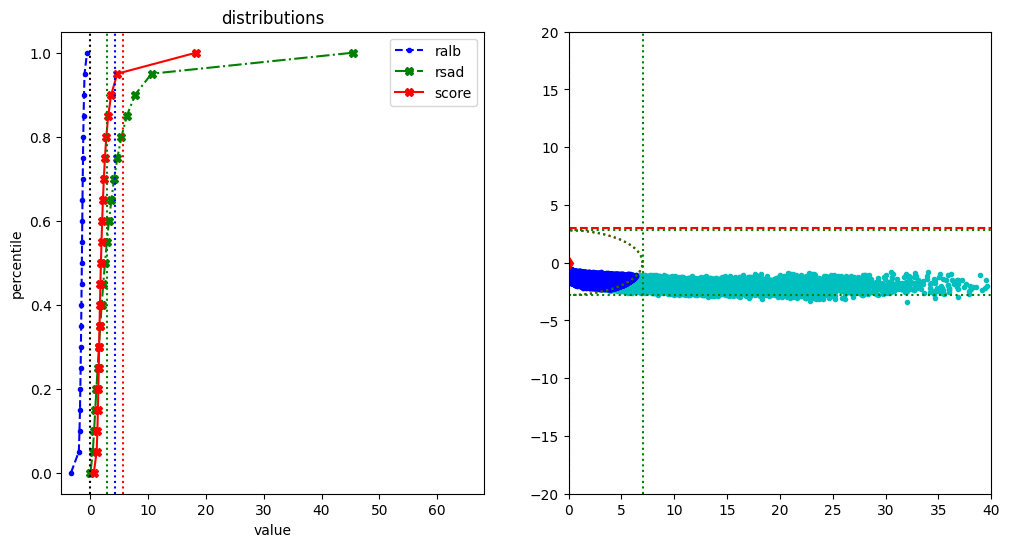

QA var:   msi_qa_score ['msi04', 'msi03', 'msi02']


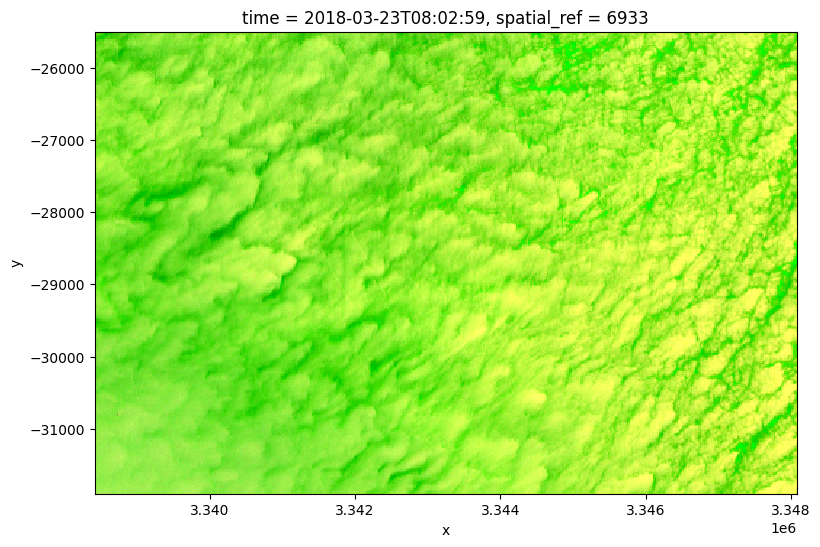

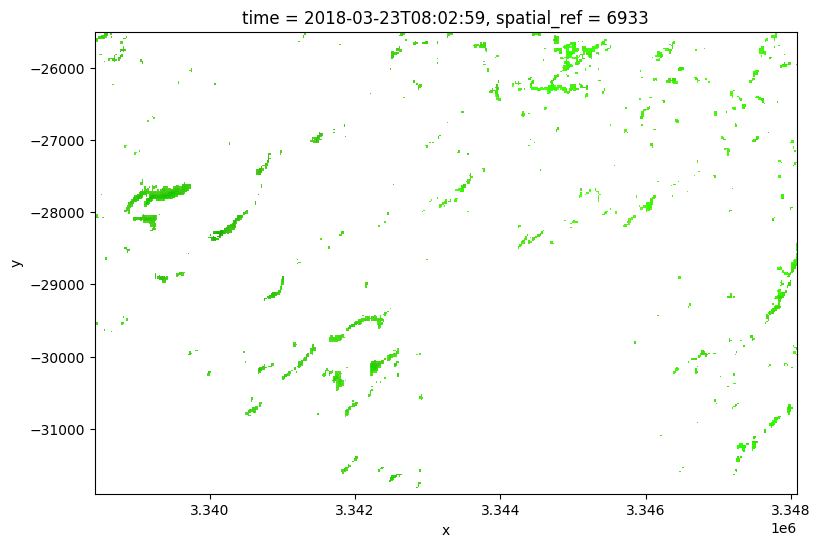

In [99]:
#i = 15   #lake vic 2015-05-03

t = ds.time[i]
print(i)

# figure out if we are using an oli or a tm image;

oli_slice = [False,'oli_qa_score','oli_qa_ralb','oli_qa_rsad']
tm_slice  = [False,'tm_qa_score','tm_qa_ralb','tm_qa_rsad']
msi_slice = [False,'msi_qa_score','msi_qa_ralb','msi_qa_rsad']


oli_score_upper      = 1.4 * 2   # this seems best ...
msi_score_upper      = 1.4 * 2   # this seems best ...
tm_score_upper       = 1.4 * 3   # should need higher threshold for tm v oli ... not a nice step to take ..

if t in list(ds_oli.time):
    oli_slice[0]        = True
    oli_timeindex       = list(ds_oli.time).index(t)
    prefix = 'oli_qa'
    score_upper = oli_score_upper
    print('OLI')

else :
    if t in list(ds_tm.time):
        tm_slice[0]  = True
        tm_timeindex = list(ds_tm.time).index(t)
        prefix = 'tm_qa'
        score_upper = tm_score_upper
        print('TM')
    else :
        if t in list (ds_msi.time):
            msi_slice[0]  = True
            msi_timeindex = list(ds_msi.time).index(t)
            prefix = 'msi_qa'
            score_upper = msi_score_upper
            print('MSI')
            

# cumulative distribution stats:
start = 0;step=.05;stop=1+step

x    = np.arange(start,stop,step)
size = x.size
data = np.zeros([4,x.size])
data[0] = x
j = 0

for percent in x:
    k = 1
    string = 'Quantile = '+str(percent)+'  '
    for var in list(('ralb','rsad','score')):
        string = string + '  '+var+str(' : ')
        v      =  ds[prefix+'_'+var].sel(time=t).quantile(percent,).round(3).item()
        string = string+str(v)
        data[k,j] = v
        k = k + 1
    j = j+1
    print(string)


plt.figure(figsize=[12, 6])
plt.subplot(1,2,1)

plt.plot(data[1],data[0],'b',linestyle="--", marker=".",label='rsalb')  #ralb
plt.plot(data[2],data[0],'g',linestyle="-.", marker="X")  #rsad
plt.plot(data[3],data[0],'r',linestyle="-", marker="X")  #score
plt.axvline(x=0 ,linestyle=':',color='k')
plt.axvline(x=1.4 * 4,linestyle=':',color='r')
plt.axvline(x=1.4 * 3,linestyle=':',color='b')
plt.axvline(x=1.4 * 2,linestyle=':',color='g')

plt.title('distributions')
                 
plt.xlabel('value')
plt.ylabel('percentile')
plt.legend(['ralb','rsad','score'])

# --- parameters for the range of the plot --- 
ymin  = 0;
xmin   = np.max([np.min(data[1:,:]) * 1.5,-100])

xmax   = np.min([np.max(data[1:,:]) * 1.5,100])

plt.xlim(xmin,xmax)

plt.subplot(1,2,2)

i = i
print(i)
time = ds.time[i]
print(time.dt.year.item(),'-',time.dt.month.item(),'-',time.dt.day.item(),i,oli_slice[0],tm_slice[0])


#plt.figure(figsize=[12, 6])
if oli_slice[0]:
    print('plotting OLI points')
    plt.scatter(ds.sel(time=time).oli_qa_rsad,ds.sel(time=time).oli_qa_ralb,marker='.',color='c')
    plt.scatter(ds.where(ds.oli_qa_score<oli_score_upper).sel(time=time).oli_qa_rsad,
                ds.where(ds.oli_qa_score<oli_score_upper).sel(time=time).oli_qa_ralb,marker='.',color = 'b')
if tm_slice[0]: 
    print('plotting TM points')
    plt.scatter(ds.sel(time=time).tm_qa_rsad,ds.sel(time=time).tm_qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.tm_qa_score<tm_score_upper).sel(time=time).tm_qa_rsad,
                ds.where(ds.tm_qa_score<tm_score_upper).sel(time=time).tm_qa_ralb,marker='.',color = 'b')
if msi_slice[0]: 
    print('plotting MSI points')
    plt.scatter(ds.sel(time=time).msi_qa_rsad,ds.sel(time=time).msi_qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.msi_qa_score<msi_score_upper).sel(time=time).msi_qa_rsad,
                ds.where(ds.msi_qa_score<msi_score_upper).sel(time=time).msi_qa_ralb,marker='.',color = 'b')


plt.plot(0,0,marker='d',color='r')
t = np.linspace(0,2*np.pi,100)
r0 = 1.4 

x,y = np.cos(t)/rsad_factor,np.sin(t)
#plt.plot(x*1*r1,y*r0,linestyle='-.',color='g')
#plt.plot(x*2*r1,y*2*r0,linestyle='--',color='b')
#plt.plot(x*score_upper*r1,y*score_upper*r0,linestyle='--',color='r')
plt.plot(score_upper*x,score_upper*y,linestyle='dotted',color='r')
plt.plot(2*r0*x,2*r0*y,linestyle='dotted',color='g')

plt.axvline(x=0,color='r',linestyle=':')
plt.axvline(x=0+2*r0/rsad_factor,color='g',linestyle=':')
plt.axhline(y=0-2*r0,color='g',linestyle=':')
plt.axhline(y=0+2*r0,color='g',linestyle=':')
plt.axhline(y=-lower_albedo,color='r',linestyle='--')

plt.xlim([0,40])
plt.ylim([-20,20])

plt.show()



    
if oli_slice[0] == True :
    rgb(ds_oli,
        #    col='time',
        #    col_wrap = 4,
        bands=['oli04','oli03','oli02'],
        index =oli_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )

if tm_slice[0] == True:
    rgb(ds_tm,
        #    col='time',
        #    col_wrap = 4,
        bands=['tm03','tm02','tm01'],
        index =tm_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )
if msi_slice[0] == True:
    rgb(ds_msi,
        #    col='time',
        #    col_wrap = 4,
        bands=['msi04','msi03','msi02'],
        index =msi_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )


if oli_slice[0]: 
    qa_var = oli_slice[1]
    qa_ralb = oli_slice[2]
    qa_rsad = oli_slice[3]
    rgbbands=['oli04','oli03','oli01']
    cutoff = score_upper
    
if tm_slice[0] : 
    qa_var = tm_slice[1]
    qa_ralb = tm_slice[2]
    qa_rsad = tm_slice[3]
    rgbbands=['tm03','tm02','tm01']
    cutoff = tm_score_upper

if msi_slice[0] : 
    qa_var = msi_slice[1]
    qa_ralb = msi_slice[2]
    qa_rsad = msi_slice[3]
    rgbbands=['msi04','msi03','msi02']
    cutoff = msi_score_upper
    
print('QA var:  ',qa_var, rgbbands)


lower_albedo = -3
upper_rsad   = 15
upper_albedo = 50



#rgb(ds.where(np.logical_and(ds[qa_var]<cutoff,ds[qa_ralb]>lower_albedo),np.nan),
rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )


i = i + 1
i = 26


In [56]:
i= 21

In [38]:
ds.data_vars

Data variables:
    oli01         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli02         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli03         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli04         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli05         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli06         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli07         (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_pq        (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_ralb   (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_alb    (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_rsad   (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_sad    (time, y, x) float64 77MB nan nan nan nan ... nan nan nan nan
    oli_qa_score  (time,

In [39]:
rgbbands

['msi04', 'msi03', 'msi02']

In [45]:
timeindex = 15
rgbbands = ['msi04', 'msi03', 'msi02']
rgbbands = ['msi07', 'msi03', 'msi02']
ds['ndvi'] = (ds.msi07 - ds.msi04)/(ds.msi07 + ds.msi04)
ds['ndvi'] = xr.where(~np.isnan(ds.ndvi),ds.ndvi,
                      (ds.oli05 - ds.oli04)/(ds.oli05 + ds.oli04))
ds['ndvi'] = xr.where(~np.isnan(ds.ndvi),ds.ndvi,
                      (ds.tm04 - ds.tm03)/(ds.tm04 + ds.tm03))


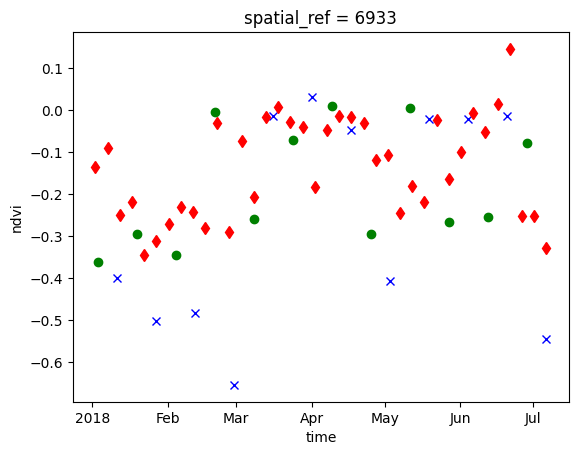

In [65]:
#ds.ndvi.mean(dim=('x','y')).plot(marker='.',linestyle='')
#ds.ndvi.median(dim=('x','y')).plot()

ds.ndvi.where(~np.isnan(ds.oli02)).median(dim=('x','y')).plot(linestyle='',marker='x',color='b')
ds.ndvi.where(~np.isnan(ds.msi02)).median(dim=('x','y')).plot(linestyle='',marker='d',color = 'r')
ds.ndvi.where(~np.isnan(ds.tm02)).median(dim=('x','y')).plot(linestyle='',marker='o',color='g')



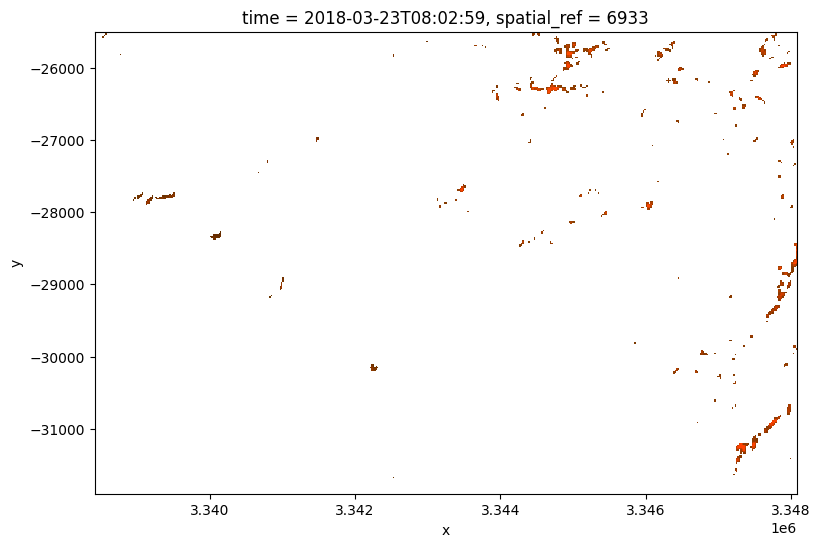

In [109]:
#timeindex  = 0 
rgb(ds.where(ds.ndvi > 0.5),
    bands=rgbbands,
    index =timeindex,
    
    index_dim='time',
 
    percentile_stretch = (.1,.99)
    )
timeindex = timeindex + 1

In [ ]:
plt.figure(figsize=[12, 6])
n = 3
m = int(ds.time.size / n)+1
c = 1
for time in ds.time:
    plt.subplot(3,2,1)
    plt.scatter(ds.sel(time=time).oli_qa_rsad,ds.sel(time=time).oli_qa_ralb,marker='.')


In [26]:
print('min = ',np.array(ds_oli.oli_qa_prod.min(dim=('x','y'))))
for q in np.arange(0,1.1,.1):
    print(
        q,ds_oli.oli_qa_ralb.isel(time=i).quantile(q,).item(),
          ds_oli.oli_qa_rsad.isel(time=i).quantile(q,).item(),
          ds_oli.oli_qa_prod.isel(time=i).quantile(q,).item(),
    )
    
print('max = ',np.array(ds_oli.oli_qa_prod.max(dim=('x','y'))))
n = np.arange(0,1.1,.1).size
results = np.
for mmt in list('ralb','rsad','prod'):
    for percentage in np.arange(0,1.1,.1):
        


SyntaxError: invalid syntax (2400415397.py, line 11)

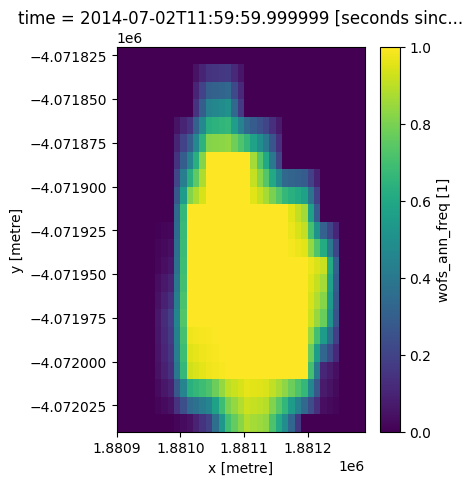

In [27]:
ds_annual.wofs_ann_freq.isel(time=0).plot(aspect = 0.8,size = 5)

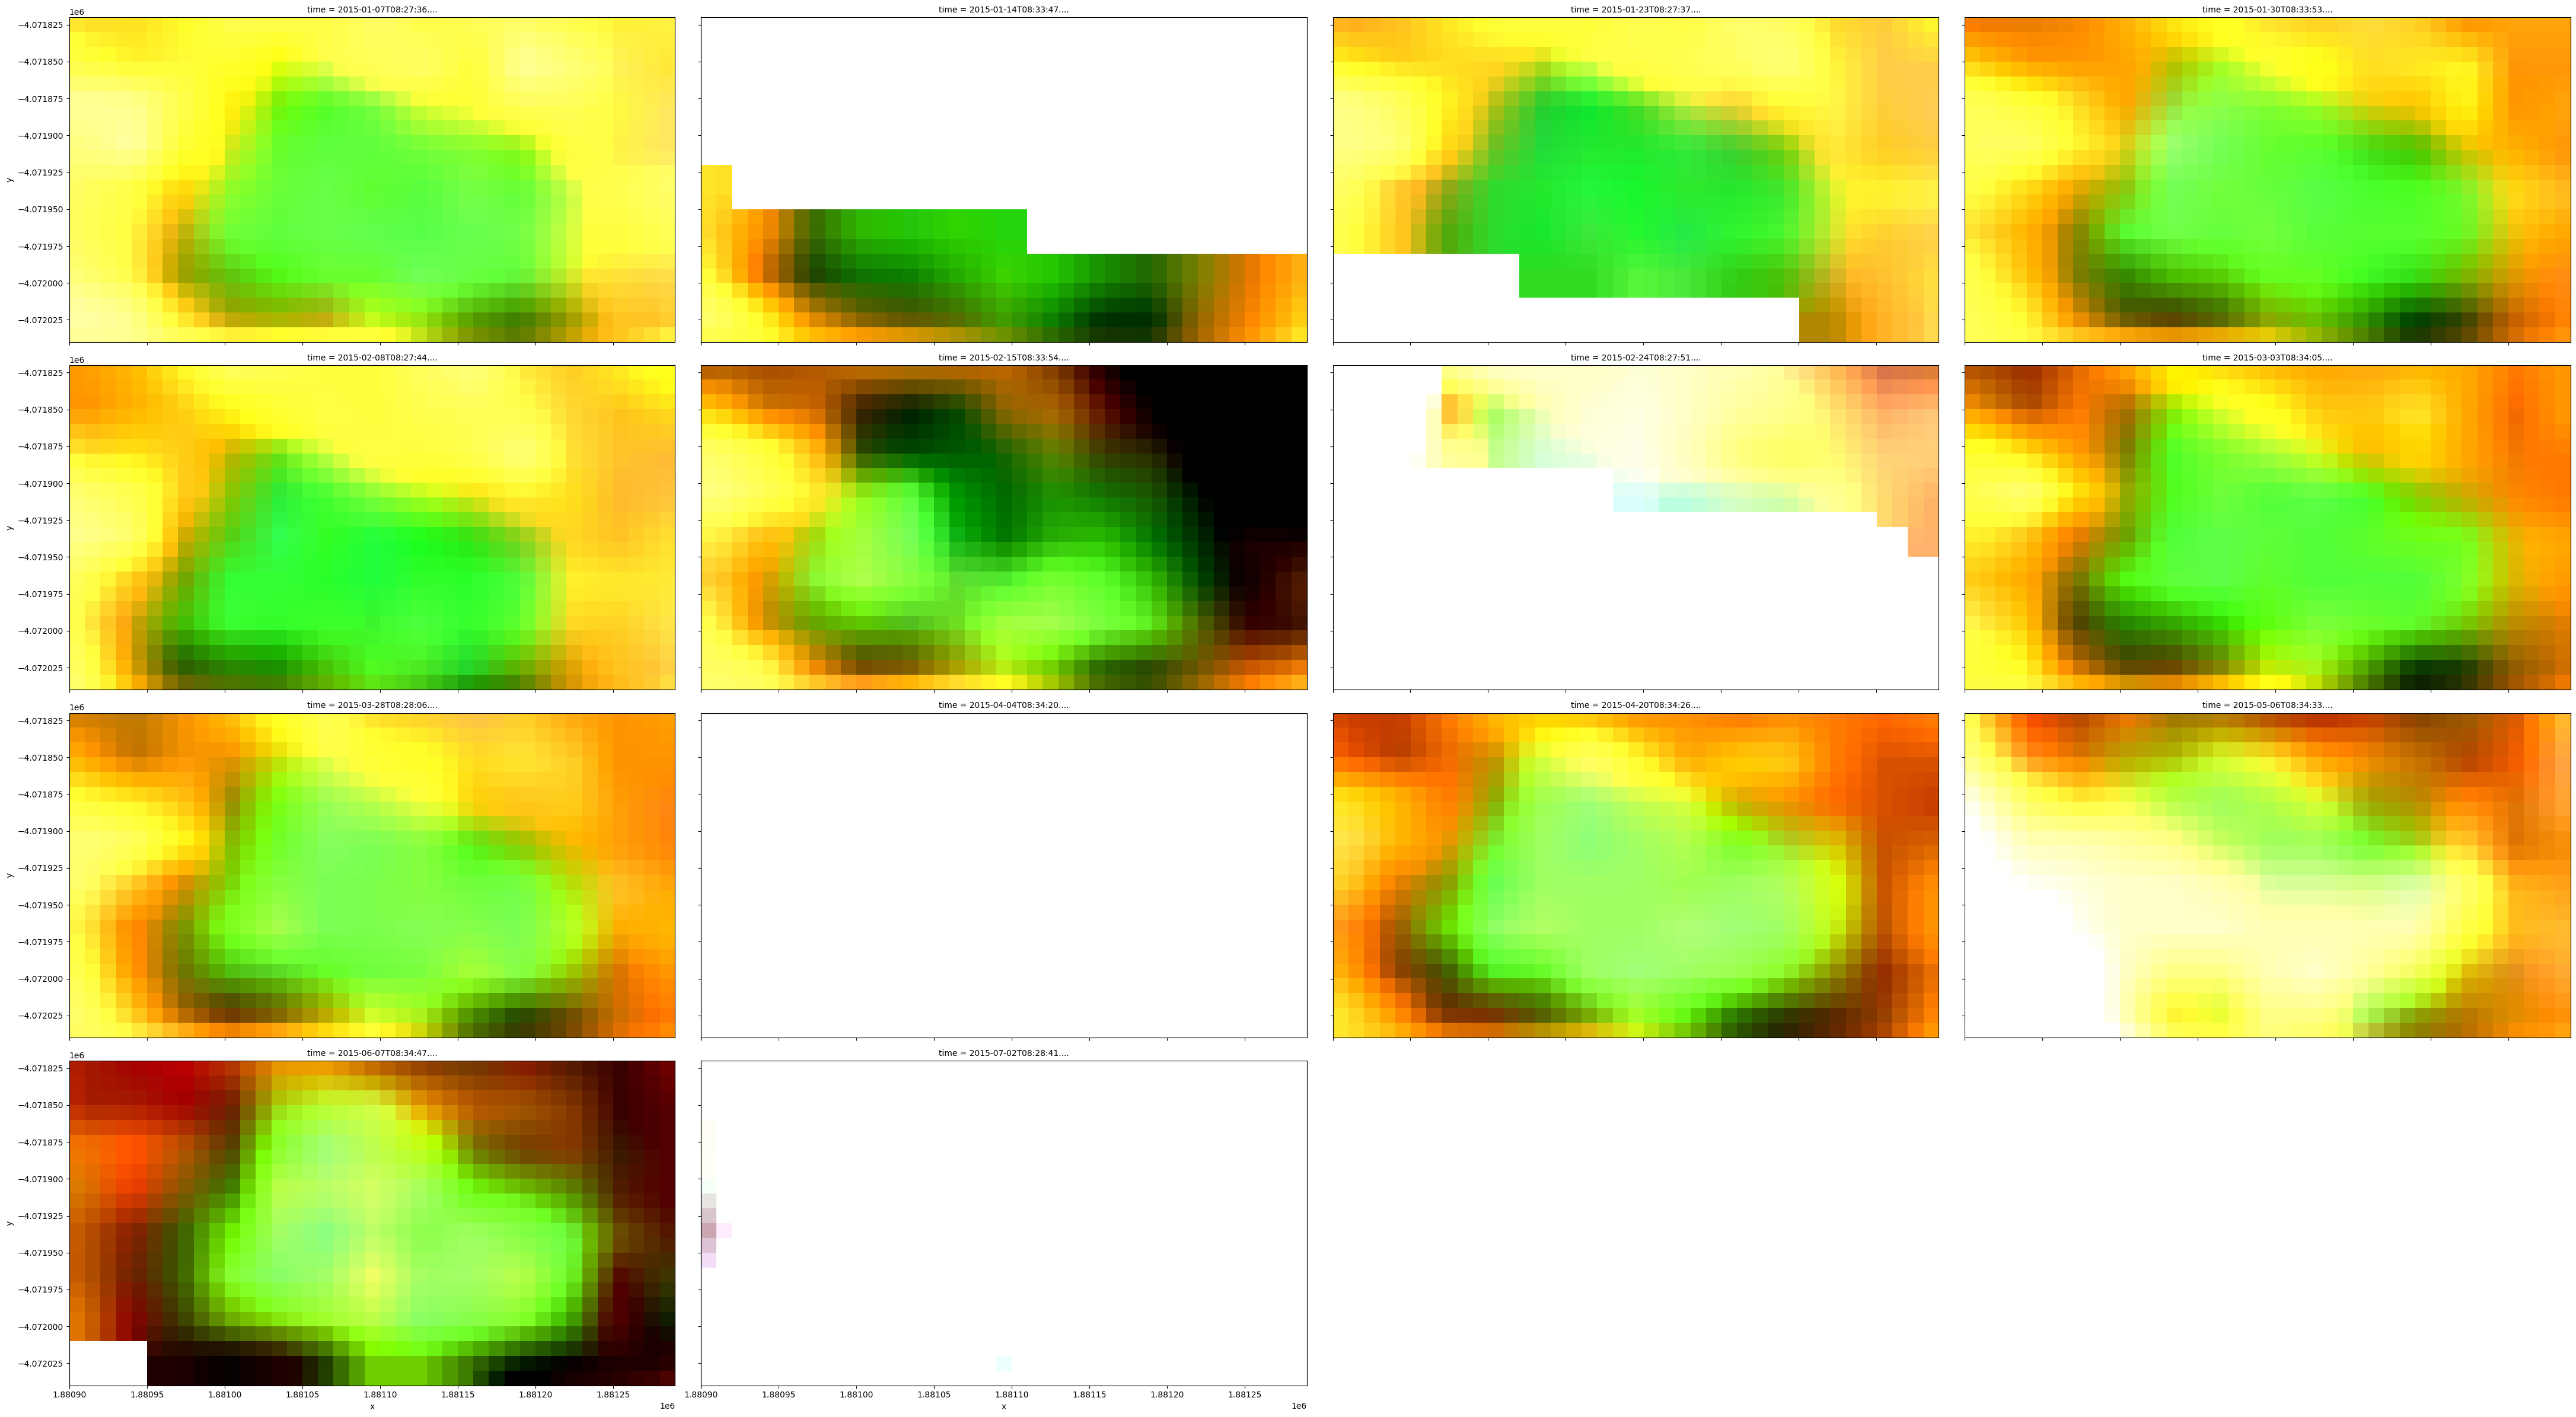

In [120]:
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
lower =  -5;   #
upper =  7.5; #  10 is also ok...  5 is too tough; 50 keeps almost all good data. 

rgb(ds_tm,
    col='time',
    col_wrap = 4,
    bands=['tm03','tm02','tm01'],
#    index =i,
    #index_dim='time',
    #robust=True,
    #aspect = .8,
    percentile_stretch = (.1,.65)
   )

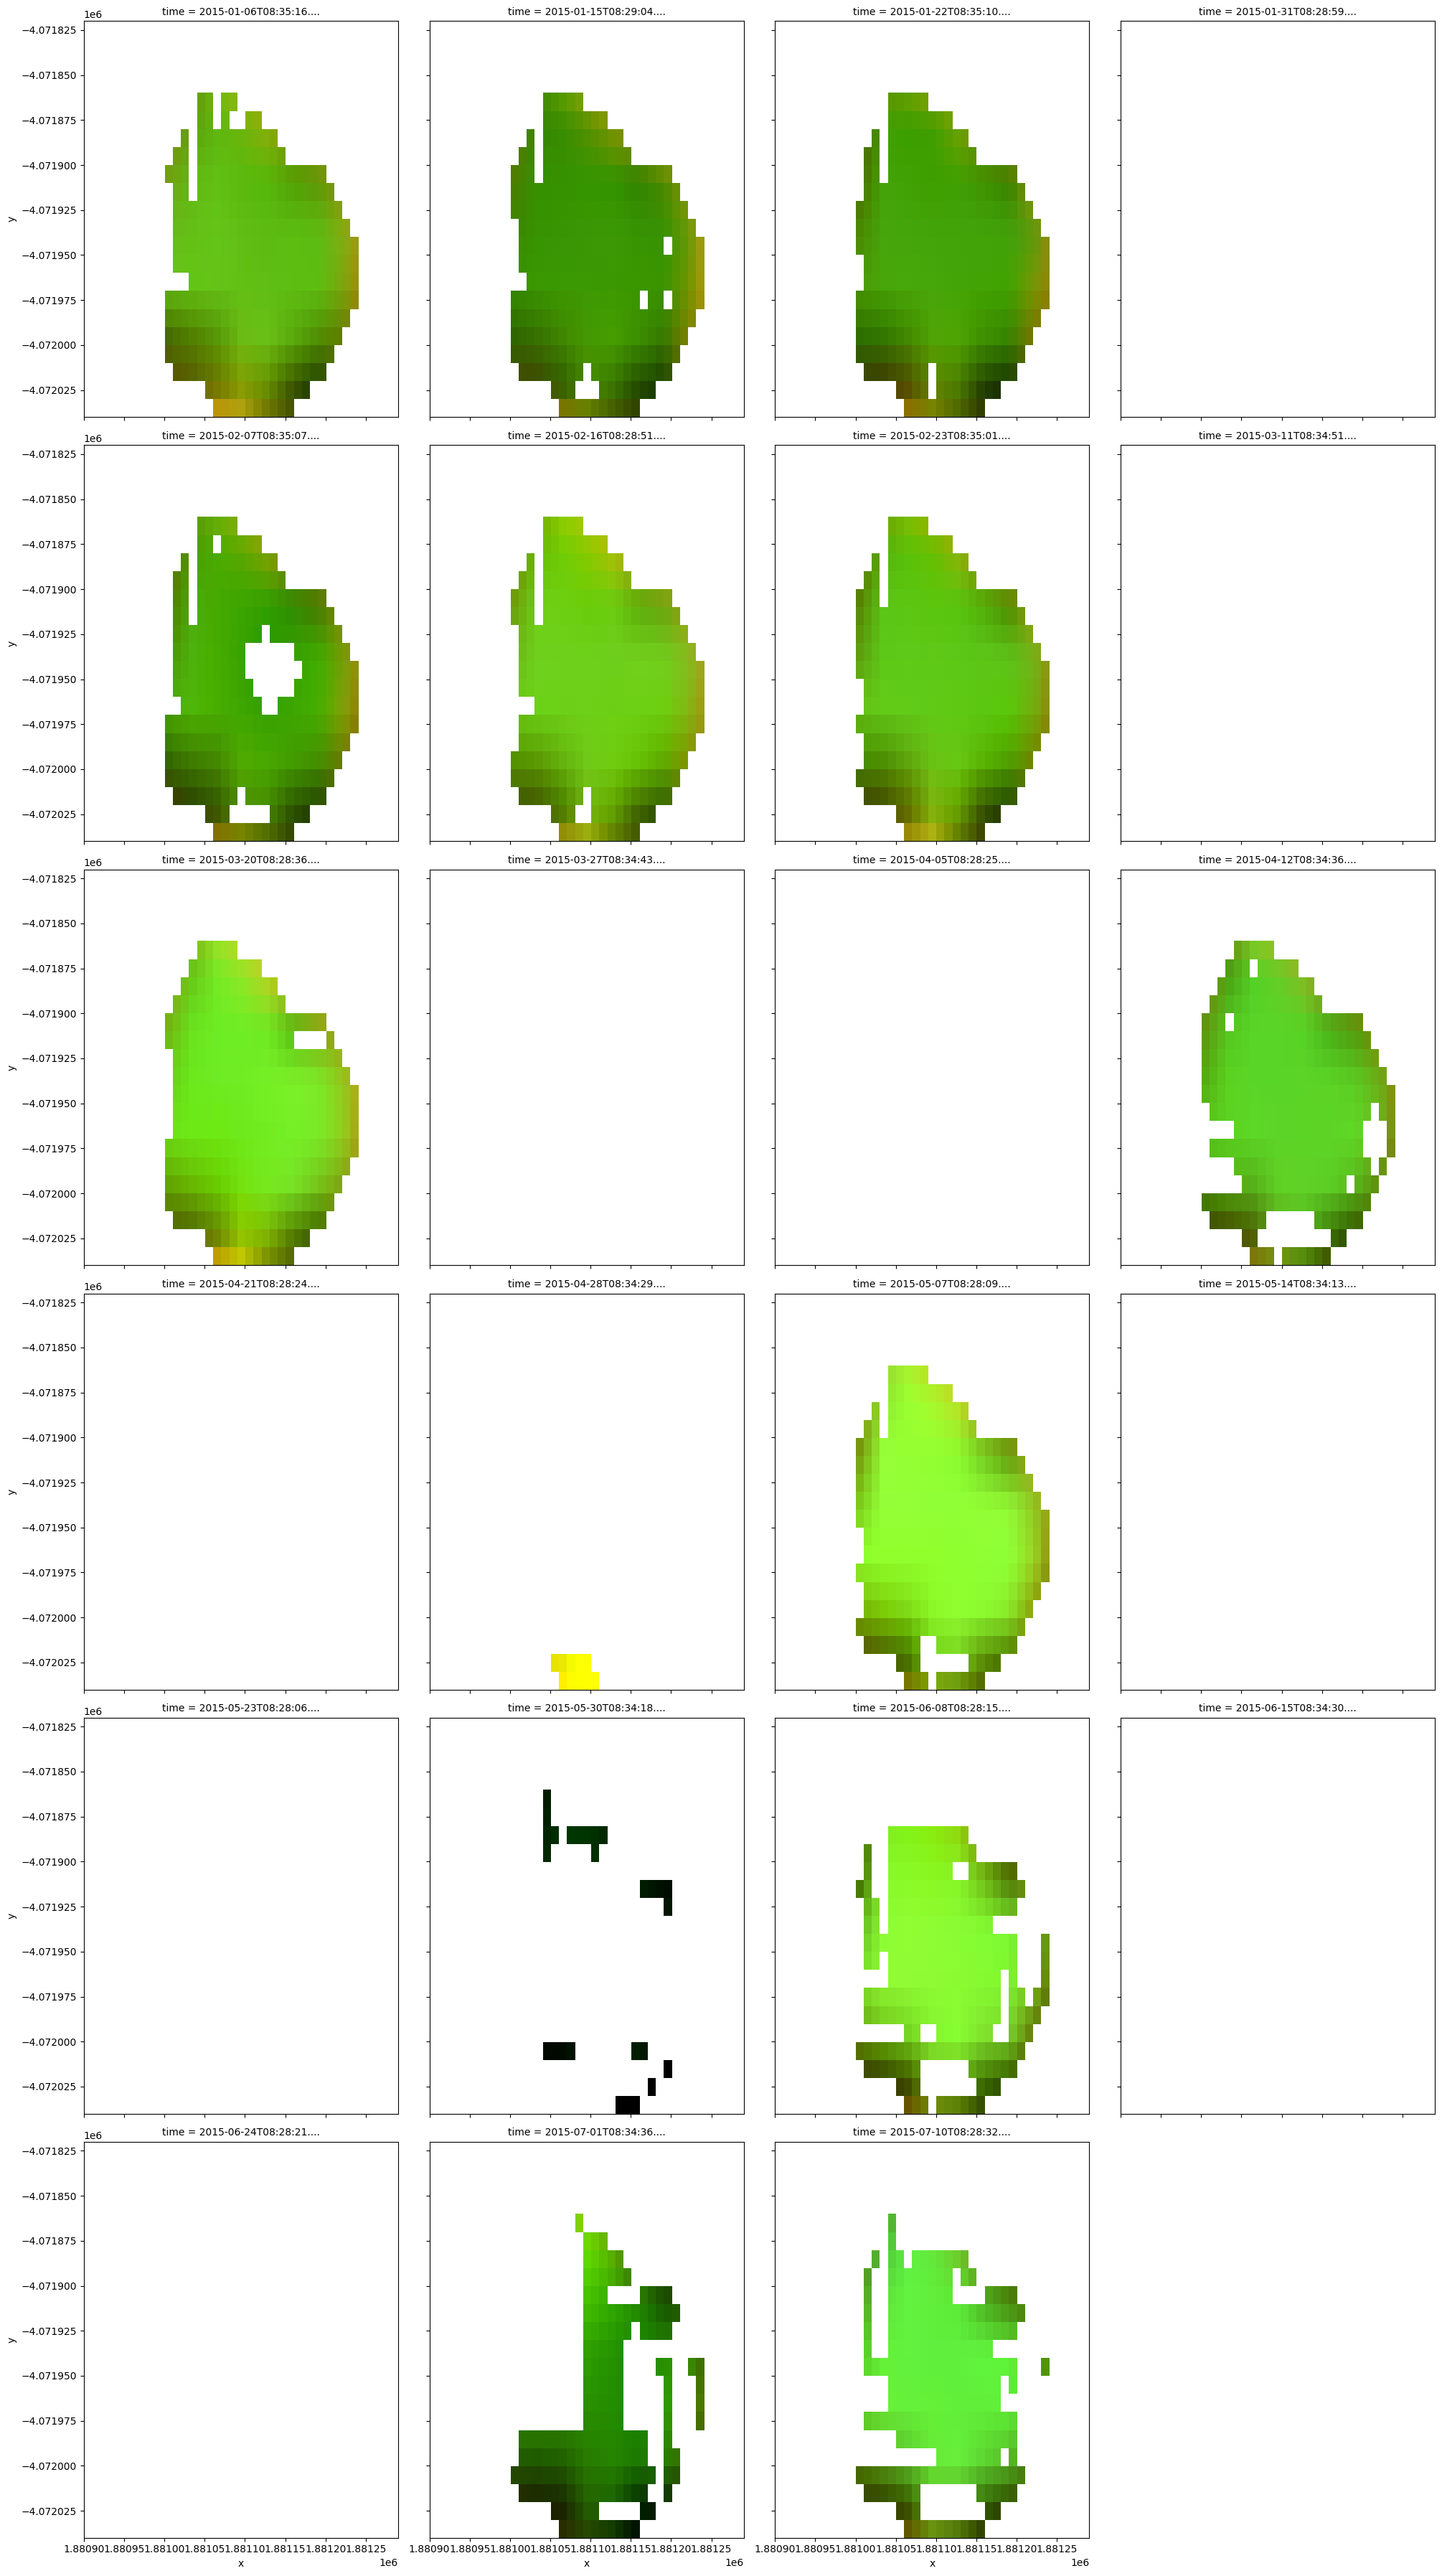

In [89]:
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
upper = .75 # upper looks okay to not filter out tubid plumes (0.75), but misses some clouds
lower =  -5;   #
upper =  7.5; #  10 is also ok...  5 is too tough; 50 keeps almost all good data. 
scale_upper = 1.4 * 3

#rgb(ds.where(np.logical_and(ds_oli['oli_qa_prod']>lower,ds_oli['oli_qa_prod']<upper),np.nan),
rgb(ds.where(np.logical_and(ds_oli['oli_qa_scale']<scale_upper,True),np.nan),
    col='time',
    col_wrap = 4,
    bands=['oli04','oli03','oli01'],
#    index =i,
    #index_dim='time',
    #robust=True,
    #aspect = .8,
   percentile_stretch = (.1,.99)
   )

In [ ]:
#this is the core of 'rgb'
if len(index) > 1:

            img = da.plot.imshow(
                robust=robust,
                col=index_dim,
                col_wrap=col_wrap,
                **aspect_size_kwarg,
                **kwargs,

#img = da.squeeze(dim=index_dim).plot.imshow(
                robust=robust, **aspect_size_kwarg, **kwargs


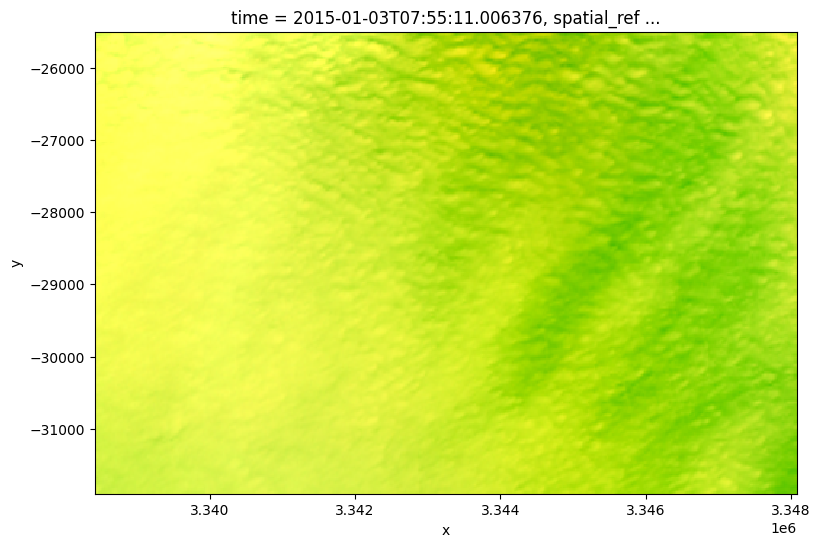

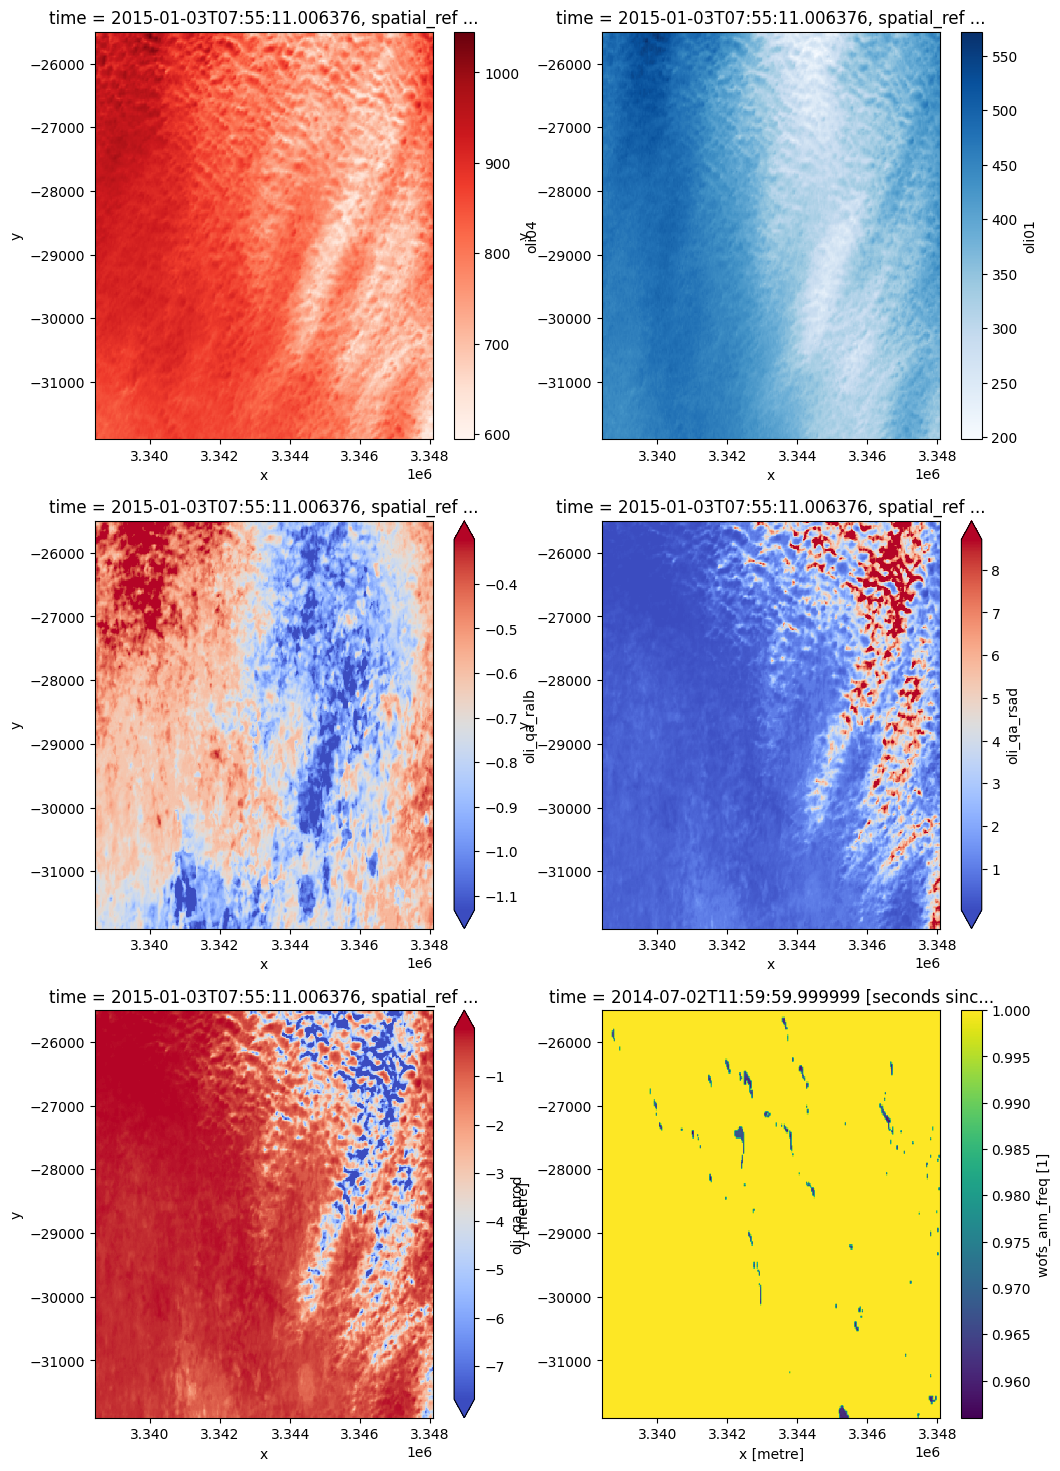

In [114]:
lower =  -100;   #
upper =  7.5; #  10 is also ok...  5 is too tough; 50 keeps almost all good data. 

year = ds.time[i]
upper = 7.5

rgb(ds,
   bands=['oli04','oli03','oli02'],
   index = i,
   index_dim='time',
    #robust=True,
   percentile_stretch = (.05,.95)
   )


plt.figure(figsize=(12,18))
plt.subplot(3,2,1)
ds.oli04.sel(time=year).plot(robust=False,cmap='Reds')
plt.subplot(3,2,2)
ds.oli01.sel(time=year).clip(0,100000).plot(cmap='Blues',robust=False)
plt.subplot(3,2,3)
ds.oli_qa_ralb.sel(time=year).plot(robust=True,cmap='coolwarm')
plt.subplot(3,2,4)
ds.oli_qa_rsad.sel(time=year).plot(robust=True,cmap='coolwarm')
plt.subplot(3,2,5)
ds.oli_qa_prod.sel(time=year).plot(robust=True,cmap='coolwarm')
plt.subplot(3,2,6)
ds_annual.wofs_ann_freq.isel(time=0).plot()

#ds.tss.sel(time=year).median(dim='tss_measure').plot(robust=True,cmap='coolwarm')
#plt.subplot(3,2,5)
#ds.chla.sel(time=year).median(dim='chla_measure').plot(robust=True,cmap='Greens')
plt.show()

### After extracting the data:
- re-scale  any oli or tm data
- remove outliers
- summarise to month

In [168]:
def rescale_oli_data(ds):
# --- re-scale the oli data --- 
    oli_rescale_vars = ("oli01","oli02","oli03","oli04","oli05","oli06","oli07") 
    for var in (oli_rescale_vars):
        if var in np.asarray(ds.data_vars):
            if verbose or test: print('rescaling',var)
            ds[var] =  ((2.75e-5 * ds[var]) - 0.2 ) * 10000
    return(ds)

In [172]:
temp = rescale_oli_data(dsets['oli'].copy())

rescaling oli01
rescaling oli02
rescaling oli03
rescaling oli04
rescaling oli05
rescaling oli06
rescaling oli07


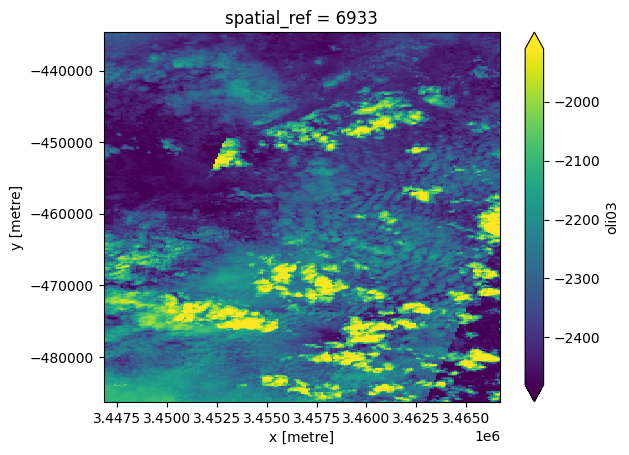

In [175]:
dsets['oli'].oli03.max(dim=('time')).plot(robust=True)

In [146]:
def rescale_tm_data(ds):
# --- re-scale the oli data --- 
    tm_rescale_vars = ("tm01","tm02","oli03","oli04","oli05","oli06","oli07") 
    for var in (oli_rescale_vars):
        if var in np.asarray(ds.data_vars):
            ds[var] =  ((2.75e-5 * ds[var]) - 0.2 ) * 10000
    return(ds)

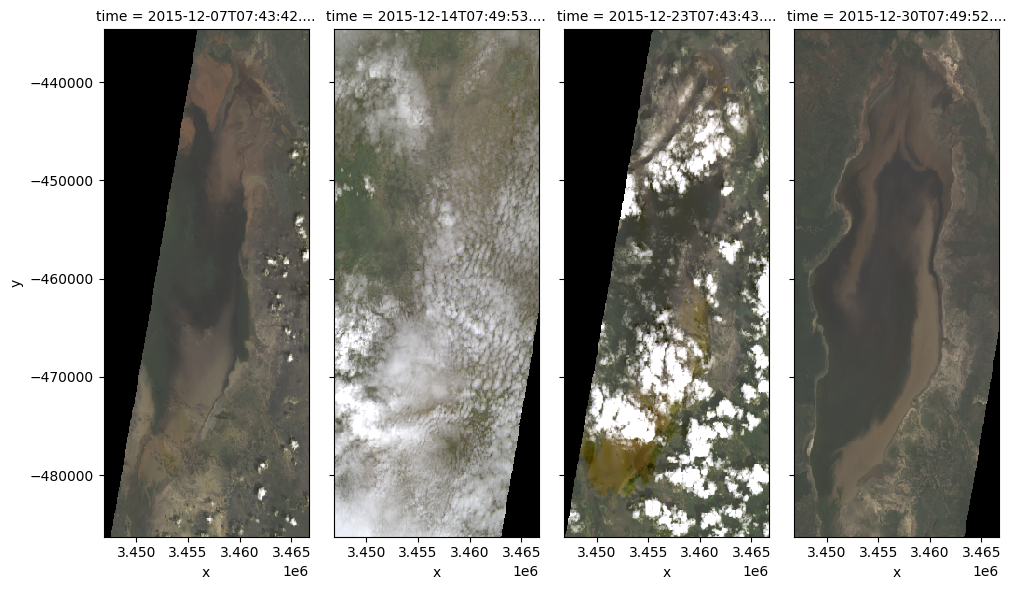

In [70]:
rgb(ds,bands=['oli04','oli03','oli02'],col='time')

### Filter outliers by reference to the geomedian and pq bands



### Determine pixels that are water (sometimes, usually, permanent)

In [64]:
# --- controling parameters for water mapping on a pixel by pixel basis ---
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)
ds   = water_analysis(ds,
                   water_frequency_threshold= WFTH,
                   wofs_varname             = 'wofs_ann_freq',
                   permanent_water_threshold= PWT,
                   sigma_coefficient        = SC,
                   verbose                  = verbose,
                   test                     = test)

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### Pixel corrections

In [16]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.

dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments,water_frequency_threshold_low,verbose=verbose,test=test)

### Hue; calculation of the hue value

In [17]:
if not (('msi_agm') in instruments.keys()):
    print("skipping hue calculation as the msi_agm instrument is not in the dataset")
else: 
    ds['hue'] = hue_calculation(ds,instrument='msi_agm',test=test,verbose=verbose)[0]

In [18]:
ds['owt_msi'] = OWT_pixel(ds,'msi_agm',water_frequency_threshold=0.8,resample_rate=3,verbose=False, test=True)        


### Calculate the raw (i.e. not harmonised) water quality measurements and indices
- A dictionary is used to manage water quality algorithms and the bands that are used in them. This retains flexibility (e.g. algorithms can be run with multiple sensors) and avoids errors
- NEW DIMENSIONS are added to the dataset to house the results. One dimension is added called 'chla', and one called 'tss'. This appraoch simplifies later processing when we want to pool the measures as an ensemble. (For simplicity, I may remove this and bring in at a later stage..)



In [19]:
# ----  dictionary of instruments, bands, algorithms, and  functions -----------------------   

ndci_nir_r   =  { 
                "msi_agm"   : {'54' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi54_agm'       ,'args' : {"NIR_band" : 'msi05_agmr', "red_band":'msi04_agmr'}},
                               '64' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi64_agm'       ,'args' : {"NIR_band" : 'msi06_agmr', "red_band":'msi04_agmr'}},
                               '74' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi74_agm'       ,'args' : {"NIR_band" : 'msi07_agmr', "red_band":'msi04_agmr'}}},
                "tm_agm"    : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43_agm'                ,'args' : {"NIR_band" : 'tm04_agm'  , "red_band":'tm03_agmr'}},
                "oli_agm"   : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54_agm'               ,'args' : {"NIR_band" : 'oli05_agm' , "red_band":'oli04_agmr'}}
                }

chla_meris2b = {"msi_agm" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi_agm' ,'args' : {"band_708" : 'msi05_agmr', "band_665":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi'     ,'args' : {"band_708" : 'msi05'     , "band_665":'msi04'}}}

chla_modis2b = {"msi_agm" : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi_agm' ,'args' : {"band_748" : 'msi06_agmr', "band_667":'msi04_agmr'}},
                    "msi"     : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi'     ,'args' : {"band_748" : 'msi06'     , "band_667":'msi04'}},
                    "tm_agm"  : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm_agm'  ,'args' : {"band_748" : 'tm04_agmr' , "band_667":'tm03_agmr'}}}

ndssi_rg     = {"msi_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi_agm'       ,'args' : { "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                "msi"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi'           ,'args' : { "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                "oli_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli_agm'       ,'args' : { "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                "oli"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli'           ,'args' : { "red_band":'oli04r'    , "green_band":'oli03r'    }},
                "tm_agm"  : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm_agm'        ,'args' : { "red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                "tm"      : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm'            ,'args' : { "red_band":'tm03r'     , "green_band":'tmi02r'    }}}

ndssi_bnir   = {#"msi_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi_agm'     ,'args' : { "NIR_band":'msi08_agmr', "blue_band":'msi02_agmr'}},
                "msi"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi'         ,'args' : { "NIR_band":'msi08'     , "blue_band":'msi02_agmr'}},
                "oli_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli_agm'     ,'args' : { "NIR_band":'oli06_agm' , "blue_band":'oli02_agmr'}},
                "oli"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli'         ,'args' : { "NIR_band":'oli06'     , "blue_band":'oli02r'    }},
                #"tm_agm"  : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm_agm'      ,'args' : { "NIR_band":'tm04_agm'  , "blue_band":'tm01_agmr' }},
                "tm"      : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm'          ,'args' : { "NIR_band":'tm04'     , "blue_band":'tm01r'    }}}


ti_yu        = {#"msi_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi_agm'        ,'args' : {"NIR" : 'msi08_agmr', "Red":'msi04_agmr', "Green":'msi03_agmr'}},
                    "msi"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi'            ,'args' : {"NIR" : 'msi08'     , "Red":'msi04r'    , "Green":'msi03_agmr'}},
                    "oli_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli_agm'        ,'args' : {"NIR" : 'oli06_agm' , "Red":'oli04_agmr', "Green":'oli03_agmr'}},
                    "oli"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli'            ,'args' : {"NIR" : 'oli06'     , "Red":'oli04r'    , "Green":'oli03r'    }},
                    "tm_agm"  : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm_agm'         ,'args' : {"NIR" : 'tm04_agm'  , "Red":'tm03_agmr' , "Green":'tm02_agmr' }},
                    "tm"      : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm'             ,'args' : {"NIR" : 'tm04'      , "Red":'tm03r'     , "Green":'tmi02r'    }}}

tsm_lym      = {"oli_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "msi_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr' }},
                    "msi"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }},
                    "tm_agm"  : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }}}

spm_qiu      = {"oli_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "tm_agm"  : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }},
                    "msi_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                    "msi"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }}}

tss_zhang        = {"msi_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi_agm' ,'args' : {"blue_band" : 'msi02_agmr', "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                        "msi"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi'     ,'args' : {"blue_band" : 'msi02r'    , "red_band":'msi04r'    , "green_band":'msi03_agmr'}},
                        "oli_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli_agm' ,'args' : {"blue_band" : 'oli02_agmr', "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                        "oli"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli'     ,'args' : {"blue_band" : 'oli02r'    , "red_band":'oli04r'    , "green_band":'oli03r'    }}}

# ---- algorithms are grouped into two over-arching dictionaries ---- 
algorithms_chla = {"ndci_nir_r"   : ndci_nir_r, 
                       "chla_meris2b" : chla_meris2b, 
                       "chla_modis2b" : chla_modis2b}
algorithms_tsm  = {"ndssi_rg"     : ndssi_rg  , 
                       "ndssi_bnir"   : ndssi_bnir, 
                       "ti_yu"        : ti_yu     ,
                       "tsm_lym"      : tsm_lym   ,
                       "tss_zhang"    : tss_zhang ,
                       "spm_qiu"      : spm_qiu    }

In [20]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building  a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset 
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)
wq_varlist = np.append(tsm_vlist,chla_vlist)


### And we are Done... :)

In [22]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.4/wp21_ds_"+placename+".nc")